In [1]:
import h5py as h5
import arepo
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm import tqdm
from scipy.interpolate import interp1d
from scipy.stats import binned_statistic_2d
from numba import njit
from astropy.io import fits
import astropy.coordinates as coord
import astropy.units as u

from joblib import Parallel,delayed

basepath = '/n/holylfs05/LABS/hernquist_lab/Users/abeane/Mgdec/'

import sys
sys.path.append(basepath+'note/')

import illustris_python as il
TNGbase = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L35n2160TNG/output/'

from lowda import load_galaxy
import lowda as lwd
from scipy.spatial import KDTree

In [2]:
mpl.rc('text', usetex=True)
mpl.rc('text.latex', preamble=r"""
\usepackage{amsmath}
""")
# mpl.rcParams.update({'font.size': 22})
# mpl.rcParams['text.latex.preamble'] = [r'\usepackage{amsmath}']
# color palette
tb_c = ['#4e79a7', '#f28e2b', '#e15759', '#76b7b2', '#59a14f',
        '#edc948', '#b07aa1', '#ff9da7', '#9c755f', '#bab0ac']

columnwidth = 242.26653 / 72.27 # converts pts to inches
textwidth = 513.11743 / 72.27
textheight = 657.3189 / 72.27

mpl.rcParams.update({'font.size': 8})

In [3]:
def get_time(time, redshift=False, 
             Omega0=0.3089, 
             OmegaLambda=0.6911,
             HubbleParam=0.6774):
    HUBBLE = 3.2407789e-18
    SEC_PER_MEGAYEAR = 3.15576e13
    
    if redshift:
        a = 1./(1.+time)
    else:
        a = time
    
    fac = 2. / (3. * np.sqrt(OmegaLambda))
    ans = fac * np.arcsinh(np.sqrt(a**3 * OmegaLambda/Omega0))

    ans /= HUBBLE * HubbleParam
    ans /= SEC_PER_MEGAYEAR * 1000
    
    return ans

In [4]:
# Define a class to hold the header information
class SnapshotHeader:
    def __init__(self, header):
        self.BoxSize = header.BoxSize
        self.Composition_vector_length = header.Composition_vector_length
        self.Flag_Cooling = header.Flag_Cooling
        self.Flag_DoublePrecision = header.Flag_DoublePrecision
        self.Flag_Feedback = header.Flag_Feedback
        self.Flag_Metals = header.Flag_Metals
        self.Flag_Sfr = header.Flag_Sfr
        self.Flag_StellarAge = header.Flag_StellarAge
        self.Git_commit = header.Git_commit
        self.Git_date = header.Git_date
        self.HubbleParam = header.HubbleParam
        self.MassTable = header.MassTable
        self.NumFilesPerSnapshot = header.NumFilesPerSnapshot
        self.NumPart_ThisFile = header.NumPart_ThisFile
        self.NumPart_Total = header.NumPart_Total
        self.NumPart_Total_HighWord = header.NumPart_Total_HighWord
        self.Omega0 = header.Omega0
        self.OmegaBaryon = header.OmegaBaryon
        self.OmegaLambda = header.OmegaLambda
        self.Redshift = header.Redshift
        self.Time = header.Time
        self.UnitLength_in_cm = header.UnitLength_in_cm
        self.UnitMass_in_g = header.UnitMass_in_g
        self.UnitVelocity_in_cm_per_s = header.UnitVelocity_in_cm_per_s

# Initialize the meta dictionary
meta = {}
meta['snap_list'] = np.arange(100)
meta['header'] = []
meta['redshift'] = []
meta['scale_factor'] = []
meta['time'] = []
meta['time_lookback'] = []

# Reference time
t0 = get_time(1.)

# Populate the meta dictionary with headers and other info for each snapshot
for i in meta['snap_list']:
    header = arepo.Snapshot(TNGbase, i, onlyHeader=True)
    
    # Create a new SnapshotHeader instance with the header data
    header_info = SnapshotHeader(header)
    
    # Store header information in meta['header']
    meta['header'].append(header_info)
    
    # Store other attributes in the respective arrays
    meta['redshift'].append(header_info.Redshift)
    meta['scale_factor'].append(header_info.Time)
    meta['time'].append(get_time(header_info.Time))
    meta['time_lookback'].append(t0 - get_time(header_info.Time))

# Store HubbleParam as an example of accessing a header property
meta['HubbleParam'] = meta['header'][0].HubbleParam

# Convert lists to numpy arrays for numerical operations
meta['redshift'] = np.array(meta['redshift'])
meta['scale_factor'] = np.array(meta['scale_factor'])
meta['time'] = np.array(meta['time'])
meta['time_lookback'] = np.array(meta['time_lookback'])

In [5]:
@njit
def rodrigues_formula(k, v, theta):
    N = v.shape[0]
    v_rot = np.zeros(np.shape(v))
    
    ctheta = np.cos(theta)
    stheta = np.sin(theta)
    
    for i in range(N):
        v_rot[i] = v[i] * ctheta + np.cross(k, v[i]) * stheta + k * (np.dot(k, v[i])) * (1-ctheta)
    
    return v_rot

In [6]:
def get_rot_pos_vel(subID, snapnum, ptype=4, rhalf_fac=2,
                    k=None, theta=None, return_k_theta=False, key_rhalf=10, Nmin=4000):
    # get COM, COMV, and ang mom of stars
    # print('loading snapnum=', snapnum, 'subID=', subID)
    subhalo = il.groupcat.loadSingle(TNGbase, snapnum, subhaloID=subID)
    # print('done loading snapnum=', snapnum, 'subID=', subID)
    # print('halfmass rad type=', subhalo['SubhaloHalfmassRadType'])
    grpID = subhalo['SubhaloGrNr']
    snap = {}
    snap[4] = il.snapshot.loadHalo(TNGbase, snapnum, grpID, 4)
    if ptype != 4:
        snap[ptype] = il.snapshot.loadHalo(TNGbase, snapnum, grpID, ptype)
    
    COM = subhalo['SubhaloPos']
    # print(np.median(snap[4]['Coordinates'], axis=0), COM)
    
    pos = snap[4]['Coordinates'] - COM
    r = np.linalg.norm(pos, axis=1)
    
    rhalf = subhalo['SubhaloHalfmassRadType'][4]

    in_rhalf = r < rhalf_fac * rhalf
    is_star = snap[4]['GFM_StellarFormationTime'] > 0
    is_star_in_rhalf = np.logical_and(is_star, in_rhalf)
    
    # for later, all stars in key_rhalf
    rpt = np.linalg.norm(snap[ptype]['Coordinates'] - COM, axis=1)
    in_key_rhalf = rpt < key_rhalf * rhalf
    if ptype==4:
        in_key_rhalf = np.logical_and(is_star, in_key_rhalf)
    
    if np.sum(is_star_in_rhalf) < Nmin:
        return None, None, None, None
    
    vel_in_rhalf = snap[4]['Velocities'][is_star_in_rhalf]
    mass_in_rhalf = snap[4]['Masses'][is_star_in_rhalf]
    # print(rhalf, np.sum(is_star_in_rhalf), np.sum(mass_in_rhalf))
    COMV = np.average(vel_in_rhalf, axis=0, weights=mass_in_rhalf)
    
    vel = snap[4]['Velocities'] - COMV
    
    ang = np.cross(pos[is_star_in_rhalf], vel[is_star_in_rhalf])
    ang *= mass_in_rhalf.reshape(-1, 1)
    ang = np.sum(ang, axis=0)
    
    ang_mom = ang

    angmom_dir = ang_mom/np.linalg.norm(ang_mom)
    if theta is None:
        theta = np.arccos(np.dot(angmom_dir, np.array([0, 0, 1])))
    if k is None:
        k = np.cross(ang_mom, np.array([0, 0, 1.]))
        k /= np.linalg.norm(k)
    
    pos = snap[ptype]['Coordinates'] - COM
    vel = snap[ptype]['Velocities'] - COMV
    mass = snap[ptype]['Masses']
    
    pos_rot = rodrigues_formula(k, pos.astype(np.float64), theta)
    vel_rot = rodrigues_formula(k, vel.astype(np.float64), theta)
    
    pos_rot *= meta['header'][snapnum].Time/meta['header'][snapnum].HubbleParam
    vel_rot *= np.sqrt(meta['header'][snapnum].Time)
    
    if return_k_theta:
        return k, theta
    
    return pos_rot, vel_rot, mass, in_key_rhalf

In [7]:
def gadget_spline(u, h=1, M=1):
    pre = M * 8 / (np.pi * h**3)
    ans = np.zeros_like(u)
    ans0 = 1 - 6*u**2 + 6 * u**3
    ans1 = 2 * (1-u)**3
    
    key0 = u <= 0.5
    key1 = np.logical_and(u > 0.5, u <= 1)
    ans[key0] = ans0[key0]
    ans[key1] = ans1[key1]
    
    ans *= pre
    
    return ans

def get_sigma_interp():
    blist = np.linspace(0, 1, 1024)
    slist = np.linspace(-1, 1, 1024)
    bgrid, sgrid = np.meshgrid(blist, slist, indexing='ij')
    
    rgrid = np.sqrt(bgrid**2 + sgrid**2)
    Wgrid = gadget_spline(rgrid, 1)
    
    sigma = np.trapz(Wgrid, slist, axis=1)
    return blist, sigma

# @njit
def sum_kernel_surface_dens(xpts, ypts, x, y, M, h, bint, sigmaint):
    
    pos = np.transpose([x, y])
    sigma = np.zeros(len(xpts)*len(ypts))
    
    xgrid, ygrid = np.meshgrid(xpts, ypts, indexing='ij')
    grid = np.transpose([xgrid.ravel(), ygrid.ravel()])
    
    tree_grid = KDTree(grid)

    # now do a ball query
    ball_idx = tree_grid.query_ball_point(pos, h)
    
    ball_idx_filter = [b for b in ball_idx if b]
    
    part_idx = np.concatenate([[i] * len(b) for i,b in enumerate(ball_idx) if b])
    ball_idx = np.concatenate(ball_idx_filter)
    
    # now get impact parameter
    b = np.linalg.norm(pos[part_idx] - grid[ball_idx], axis=1)
    sigma_ = M[part_idx]/h[part_idx]**3 * np.interp(b/h[part_idx], bint, sigmaint)
    sigma = np.bincount(ball_idx, weights=sigma_, minlength=len(xpts)*len(ypts))

    sigma = np.reshape(sigma, (len(xpts), len(ypts)))

    return sigma    

In [8]:
def get_star_maps(pos, mass, L, Nres, k=None, theta=None, ptype=4):
    dL = L/Nres
    
    xbins = np.arange(-L/2, L/2.+dL, dL)
    ybins = np.arange(-L/2, L/2.+dL, dL)
    
    Hxy, _, _, _ = binned_statistic_2d(pos[:,0], pos[:,1], mass/dL/dL,
                                     statistic='sum', bins=[xbins, ybins])
    
    Hxz, _, _, _ = binned_statistic_2d(pos[:,0], pos[:,2], mass/dL/dL,
                                     statistic='sum', bins=[xbins, ybins])
    
    # get softening lengths
    # tree = KDTree(pos)
    # h, _ = tree.query(pos, 33)
    # h = h[:,-1]
    
    # bint, sigmaint = get_sigma_interp()
    # Hxy = sum_kernel_surface_dens(xpts, ypts, x, y, mass, h, bint, sigmaint)
    # Hxz = sum_kernel_surface_dens(xpts, zpts, x, z, mass, h, bint, sigmaint)
    
    return Hxy, Hxz

def get_all_maps(subID, snapnum, L, Nres, k=None, theta=None, R_A2=2):
    pos, vel, mass, key = get_rot_pos_vel(subID, snapnum, k=k, theta=theta, ptype=0)
    if pos is None:
        empty = np.zeros((Nres, Nres))
        return 0.0, empty, empty, empty, empty
    
    pos = pos[key]
    vel = vel[key]
    mass = mass[key]
    Hxy_g, Hxz_g = get_star_maps(pos, mass, L, Nres)
    
    pos, vel, mass, key = get_rot_pos_vel(subID, snapnum, k=k, theta=theta, ptype=4)
    pos = pos[key]
    vel = vel[key]
    mass = mass[key]
    Hxy_s, Hxz_s = get_star_maps(pos, mass, L, Nres)
    
    # get A2
    R = np.linalg.norm(pos[:,:2], axis=1)
    key = R < R_A2
    phi = np.arctan2(pos[:,1], pos[:,0])
    A2r = np.sum(mass[key]*np.sin(2*phi[key]))
    A2i = np.sum(mass[key]*np.cos(2*phi[key]))
    A2 = np.sqrt(A2r**2 + A2i**2)
    A0 = np.sum(mass[key])
    
    return A2/A0, Hxy_s, Hxz_s, Hxy_g, Hxz_g

In [9]:
def mdot_eddington(bh_mass):
    GRAVITY = 6.6738e-8
    CLIGHT = 2.99792458e10
    PROTONMASS = 1.67262178e-24
    THOMPSON = 6.65245873e-25
    UnitTime_in_s = meta['header'][99].UnitLength_in_cm / meta['header'][99].UnitVelocity_in_cm_per_s
    
    BlackHoleRadiativeEfficiency = 0.2
    
    ans = 4*np.pi * GRAVITY * CLIGHT * PROTONMASS / (BlackHoleRadiativeEfficiency * CLIGHT * CLIGHT * THOMPSON)
    ans *= UnitTime_in_s / meta['header'][99].HubbleParam
    ans *= np.copy(bh_mass)
    
    return ans

# alyssa plot

In [10]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

In [11]:
snap_list = np.arange(30 - 3, 30 + 6)
print(snap_list)
print(meta['redshift'][snap_list])
print(meta['time'][snap_list])

[27 28 29 30 31 32 33 34 35]
[2.73314262 2.57729027 2.4442257  2.31611074 2.20792547 2.10326965
 2.00202814 1.90408954 1.82268925]
[2.38355203 2.53859963 2.68458746 2.83866054 2.98041581 3.12893191
 3.28448342 3.44734902 3.59298306]


In [14]:
# snap_list = np.arange(99)
snap_list = np.arange(30-4, 30+7)
time = meta['time']

subID_atsnap = 392276
snap = 99
treeMPB = il.sublink.loadTree(TNGbase, snap, subID_atsnap, onlyMPB=True)
L = 10
Nres = 256
R_A2 = 2

map_dat = {}
map_dat['time'] = time
map_dat['A2A0'] = np.full_like(time, np.nan)
map_dat['BH_Hsml'] = np.full_like(time, np.nan)
map_dat['BH_Mass'] = np.full_like(time, np.nan)
map_dat['BH_Mdot'] = np.full_like(time, np.nan)
map_dat['BH_MdotEddington'] = np.full_like(time, np.nan)
map_dat['Hxy_s'] = {}
map_dat['Hxz_s'] = {}
map_dat['Hxy_g'] = {}
map_dat['Hxz_g'] = {}

for snap in tqdm(snap_list, position=0, leave=True):
    key = np.where(treeMPB['SnapNum'] == snap)[0]
    subID = treeMPB['SubfindID'][key][0]
    A2A0, Hxy_s, Hxz_s, Hxy_g, Hxz_g = get_all_maps(subID, snap, L, Nres, k=None, theta=None, R_A2=R_A2)
    
    map_dat['A2A0'][snap] = A2A0
    map_dat['Hxy_s'][snap] = Hxy_s
    map_dat['Hxz_s'][snap] = Hxz_s
    map_dat['Hxy_g'][snap] = Hxy_g
    map_dat['Hxz_g'][snap] = Hxz_g
    
    bh = il.snapshot.loadSubhalo(TNGbase, snap, subID, 5, fields=None)
    if bh['count'] > 0:
        if bh['count'] > 1:
            print('ahhh')
        map_dat['BH_Hsml'][snap] = bh['BH_Hsml'][0]
        map_dat['BH_Mass'][snap] = bh['BH_Mass'][0]
        map_dat['BH_Mdot'][snap] = bh['BH_Mdot'][0]
        map_dat['BH_MdotEddington'][snap] = bh['BH_MdotEddington'][0]
        
    

100%|██████████| 11/11 [00:16<00:00,  1.52s/it]


In [15]:
slist = np.arange(30 - 3, 30 + 6)
map_dat['BH_Hsml'][slist] * meta['scale_factor'][slist] / meta['HubbleParam']

array([0.24433161, 0.22087203, 0.24931019, 0.24697754, 0.19224745,
       0.18244752, 0.27153788, 0.19123736, 0.22007086])

In [16]:
def gen_fig_axs(textwidth=textwidth, n_subpanels=9):

    # Calculate the width of each panel
    panel_width = textwidth / n_subpanels  # Fixed panel width
    panel_height = panel_width  # Make the panels square

    # Calculate the total figure height
    top_panel_height = 2 * panel_height  # Top panel height
    total_height = top_panel_height + 2 * panel_height  # Total height of figure
    figsize = (textwidth, total_height)

    # Create figure and gridspec layout with updated height ratios
    fig = plt.figure(figsize=figsize)
    gs = gridspec.GridSpec(3, n_subpanels, height_ratios=[panel_height, panel_height, top_panel_height])

    gs.update(wspace=0.05, hspace=0.05)
    
    # Top row (12 square subpanels)
    axs_top = [fig.add_subplot(gs[0, i]) for i in range(n_subpanels)]

    # Middle row (12 square subpanels)
    axs_mid = [fig.add_subplot(gs[1, i]) for i in range(n_subpanels)]

    ax_bot = fig.add_subplot(gs[2, :])

    # Remove ticks for the middle and bottom rows
    for ax in axs_top + axs_mid:
        ax.set_xticks([])
        ax.set_yticks([])

    return fig, axs_top, axs_mid, ax_bot

2.7331426173187188 1.822689252620354
2.383552028068521 3.5929830598193426


100%|██████████| 9/9 [00:00<00:00, 278.69it/s]
/tmp/ipykernel_3348140/402625149.py:97: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


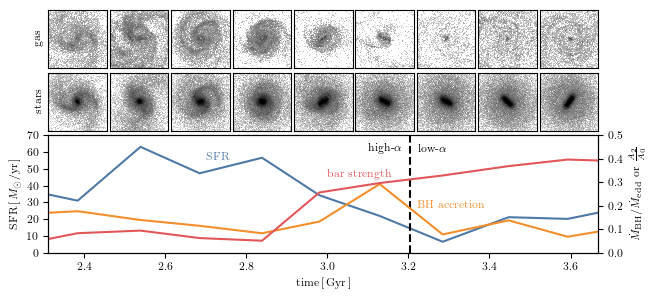

In [47]:
plt.close()
fig, axs_top, axs_mid, ax_bot = gen_fig_axs()

subID_atsnap = 392276
snap = 99
treeMPB = il.sublink.loadTree(TNGbase, snap, subID_atsnap, onlyMPB=True)
snap_list = np.arange(30 - 3, 30 + 6)
# A2max = get_A2max(treeMPB)

print(meta['redshift'][snap_list[0]], meta['redshift'][snap_list[-1]])
print(meta['time'][snap_list[0]], meta['time'][snap_list[-1]])

extent = [-L/2, L/2, -L/2, L/2]

vmax=5e-1
vmin=5e-4

A2A0_list = []
time_A2A0 = []

# get A2A0 at preceding snapshot
snap = snap_list[0]-1
key = np.where(treeMPB['SnapNum'] == snap)[0]
subID = treeMPB['SubfindID'][key][0]
A2A0, _, _, _, _ = get_all_maps(subID, snap, L, Nres, k=None, theta=None, R_A2=R_A2)
A2A0_list.append(A2A0)
time_A2A0.append(meta['time'][snap])

# plot gas and star surface density panels
for i,snap in enumerate(tqdm(snap_list, leave=True, position=0)):
    ax_top = axs_top[i]
    ax_mid = axs_mid[i]
    
    # plot gas
    Hxy_s = map_dat['Hxy_s'][snap]
    Hxy_g = map_dat['Hxy_g'][snap]
    
    Hxy_g[Hxy_g<vmin] = vmin
    ax_top.imshow(Hxy_g.T, origin='lower', extent=extent, cmap='Greys', 
              norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax), interpolation='None')
    
    # plot stars
    Hxy_s[Hxy_s<vmin] = vmin
    ax_mid.imshow(Hxy_s.T, origin='lower', extent=extent, cmap='Greys', 
              norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax), interpolation='None')

    
# plot other stuff
axs_top[0].text(-0.08, 0.5, r'$\textrm{gas}$', rotation=90, horizontalalignment='right',
                     verticalalignment='center', transform=axs_top[0].transAxes)

axs_mid[0].text(-0.08, 0.5, r'$\textrm{stars}$', rotation=90, horizontalalignment='right',
                     verticalalignment='center', transform=axs_mid[0].transAxes)

time = meta['time'][snap_list]
xlim0 = 0.5 * (meta['time'][snap_list[0]-1] + meta['time'][snap_list[0]])
xlim1 = 0.5 * (meta['time'][snap_list[-1]] + meta['time'][snap_list[-1]+1])
ax_bot.set(xlim=(xlim0, xlim1))

sfr = treeMPB['SubhaloSFR']
time = meta['time'][treeMPB['SnapNum']]
# MBHmass = treeMPB['SubhaloBHMass']
# MBHdot = treeMPB['SubhaloBHMdot']
# Medd   = mdot_eddington(MBHmass)
# fEdd = MBHdot/Medd
fEdd = map_dat['BH_Mdot']/map_dat['BH_MdotEddington']

lns0 = ax_bot.plot(time, sfr, c=tb_c[0], label=r'$\textrm{SFR}$')
ax_bot.set(ylim=(0, 70), ylabel=r'$\textrm{SFR}\,[\,M_{\odot}/\textrm{yr}\,]$')
ax_bot.set(yticks=np.arange(0, 70+10, 10))

ax2_bot = ax_bot.twinx()
lns1 = ax2_bot.plot(map_dat['time'], fEdd, c=tb_c[1], label=r'$\dot{M_{\textrm{BH}}}/\dot{M_{\textrm{edd}}}$')

lns2 = ax2_bot.plot(map_dat['time'], map_dat['A2A0'], c=tb_c[2], label=r'$\frac{A_2}{A_0}(R<2\,\textrm{kpc})$')

ax2_bot.set(xlim=(xlim0, xlim1))
ax2_bot.set(ylim=(0, 0.5), ylabel=r'$\dot{M}_{\textrm{BH}}/\dot{M}_{\textrm{edd}}\textrm{ or }\frac{A_2}{A_0}$')

# lns = lns0+lns1+lns2
# labs = [l.get_label() for l in lns]
# ax_bot.legend(lns, labs, loc=7, frameon=False)

ax_bot.axvline(get_time(1)-10.6, c='k', ls='dashed')

ax_bot.text(2.7, 55, r'$\textrm{SFR}$', c=tb_c[0])
ax2_bot.text(3.22, 0.19, r'$\textrm{BH accretion}$', c=tb_c[1])
ax2_bot.text(3, 0.32, r'$\textrm{bar strength}$', c=tb_c[2])

ttran = get_time(1)-10.6
ax_bot.text(ttran+0.02, 60, r'$\textrm{low-}\alpha$')
ax_bot.text(ttran-0.02, 60, r'$\textrm{high-}\alpha$', horizontalalignment='right')
# ax_bot.arrow(ttran+0.02, 57.5, 0.05, 0, head_width=0.02, head_length=0.01)

ax_bot.set(xlabel=r'$\textrm{time}\,[\,\textrm{Gyr}\,]$')

fig.tight_layout()
fig.savefig('alyssa.pdf')
plt.show()

In [52]:
sfr = treeMPB['SubhaloSFRinRad']
time = meta['time'][treeMPB['SnapNum']]
MBHmass = treeMPB['SubhaloBHMass']
MBHdot = treeMPB['SubhaloBHMdot']
Medd   = mdot_eddington(MBHmass)
fEdd = MBHdot/Medd

for snap in range(100):
    k = np.where(treeMPB['SnapNum'] == snap)[0][0]
    
    t = meta['time'][snap]
    z = meta['redshift'][snap]
    sfr_k = sfr[k]
    mbh = MBHmass[k]/meta['HubbleParam']/1e-2
    print('{:2d} {:05.2f} {:04.1f} {:05.2f} {:05.2f}'.format(snap, t, z, sfr_k, mbh))

 0 00.18 20.0 00.00 00.00
 1 00.27 15.0 00.00 00.00
 2 00.37 12.0 00.01 00.00
 3 00.42 11.0 00.01 00.00
 4 00.47 10.0 00.01 00.00
 5 00.52 09.4 00.03 00.00
 6 00.55 09.0 00.04 00.00
 7 00.60 08.4 00.10 00.00
 8 00.64 08.0 00.14 00.00
 9 00.69 07.6 00.20 00.00
10 00.73 07.2 00.43 00.00
11 00.76 07.0 00.33 00.00
12 00.84 06.5 00.84 00.01
13 00.93 06.0 01.62 00.01
14 00.97 05.8 01.76 00.01
15 01.04 05.5 02.59 00.01
16 01.11 05.2 03.67 00.02
17 01.18 05.0 08.76 00.02
18 01.28 04.7 08.20 00.02
19 01.37 04.4 11.91 00.02
20 01.47 04.2 19.12 00.03
21 01.54 04.0 21.04 00.03
22 01.69 03.7 19.72 00.05
23 01.81 03.5 17.77 00.07
24 01.94 03.3 23.36 00.10
25 02.15 03.0 29.97 00.17
26 02.24 02.9 34.71 00.19
27 02.38 02.7 23.94 00.25
28 02.54 02.6 48.79 00.33
29 02.68 02.4 42.22 00.40
30 02.84 02.3 54.26 00.48
31 02.98 02.2 33.35 00.61
32 03.13 02.1 20.13 00.79
33 03.28 02.0 03.62 01.00
34 03.45 01.9 12.16 01.15
35 03.59 01.8 09.22 01.28
36 03.74 01.7 16.70 01.42
37 03.90 01.7 14.56 01.64
38 04.04 01.

/tmp/ipykernel_3348140/2022317984.py:6: RuntimeWarning: invalid value encountered in divide
  fEdd = MBHdot/Medd


100%|██████████| 99/99 [00:00<00:00, 268.68it/s]
/tmp/ipykernel_3732442/432169627.py:50: RuntimeWarning: invalid value encountered in divide
  fEdd = MBHdot/Medd


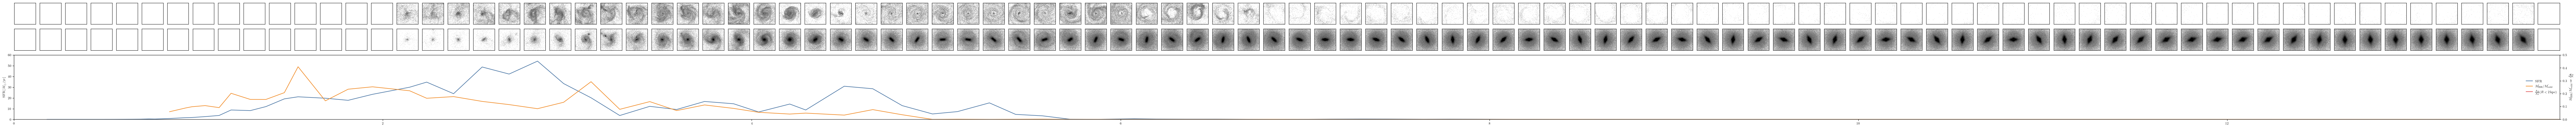

In [236]:
plt.close()
fig, axs_top, axs_mid, ax_bot = gen_fig_axs(textwidth=(100/9)*textwidth, n_subpanels=100)

subID_atsnap = 392276
snap = 99
treeMPB = il.sublink.loadTree(TNGbase, snap, subID_atsnap, onlyMPB=True)
snap_list = np.arange(99)
# A2max = get_A2max(treeMPB)

L = 10
Nres = 256
extent = [-L/2, L/2, -L/2, L/2]

vmax=5e-1
vmin=5e-4

R_A2 = 2

A2A0_list = []
time_A2A0 = []

for i,snap in enumerate(tqdm(snap_list, leave=True, position=0)):
    ax_top = axs_top[i]
    ax_mid = axs_mid[i]
    
    Hxy_s = map_dat['Hxy_s'][snap]
    Hxy_g = map_dat['Hxy_g'][snap]
    
    Hxy_g[Hxy_g<vmin] = vmin
    ax_top.imshow(Hxy_g.T, origin='lower', extent=extent, cmap='Greys', 
              norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax), interpolation='None')
    
    # plot stars
    Hxy_s[Hxy_s<vmin] = vmin
    ax_mid.imshow(Hxy_s.T, origin='lower', extent=extent, cmap='Greys', 
              norm=mpl.colors.LogNorm(vmin=vmin, vmax=vmax), interpolation='None')

# plot other stuff
time = meta['time'][snap_list]
xlim0 = 0
xlim1 = meta['time'][99]
xlim = (xlim0, xlim1)
ax_bot.set(xlim=xlim)

sfr = treeMPB['SubhaloSFRinRad']
time = meta['time'][treeMPB['SnapNum']]
MBHmass = treeMPB['SubhaloBHMass']
MBHdot = treeMPB['SubhaloBHMdot']
Medd   = mdot_eddington(MBHmass)
fEdd = MBHdot/Medd

lns0 = ax_bot.plot(time, sfr, c=tb_c[0], label=r'$\textrm{SFR}$')
ax_bot.set(ylim=(0, 60), ylabel=r'$\textrm{SFR}\,[\,M_{\odot}/\textrm{yr}\,]$')

ax2_bot = ax_bot.twinx()
lns1 = ax2_bot.plot(time, fEdd, c=tb_c[1], label=r'$\dot{M_{\textrm{BH}}}/\dot{M_{\textrm{edd}}}$')

lns2 = ax2_bot.plot(time_A2A0, A2A0_list, c=tb_c[2], label=r'$\frac{A_2}{A_0}(R<2\,\textrm{kpc})$')

ax2_bot.set(xlim=xlim)
ax2_bot.set(ylim=(0, 0.5), ylabel=r'$\dot{M_{\textrm{BH}}}/\dot{M_{\textrm{edd}}}\textrm{ or }\frac{A_2}{A_0}$')

lns = lns0+lns1+lns2
labs = [l.get_label() for l in lns]
ax_bot.legend(lns, labs, loc=7, frameon=False)

fig.tight_layout()
fig.savefig('alyssa_all.pdf')
plt.show()

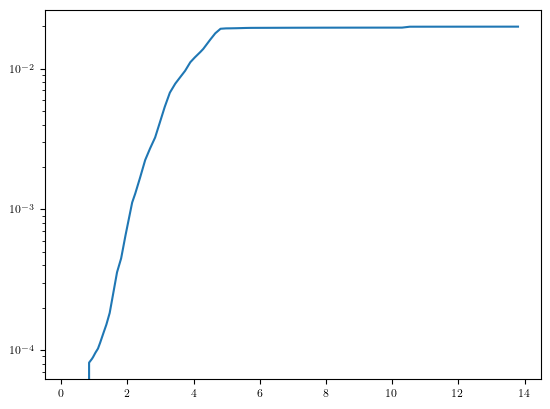

In [31]:
time = meta['time'][treeMPB['SnapNum']]
MBH = treeMPB['SubhaloBHMass']

plt.plot(time, MBH)
plt.yscale('log')

In [28]:
for k in treeMPB.keys():
    print(k)

count
DescendantID
FirstProgenitorID
FirstSubhaloInFOFGroupID
GroupBHMass
GroupBHMdot
GroupCM
GroupFirstSub
GroupGasMetalFractions
GroupGasMetallicity
GroupLen
GroupLenType
GroupMass
GroupMassType
GroupNsubs
GroupPos
GroupSFR
GroupStarMetalFractions
GroupStarMetallicity
GroupVel
GroupWindMass
Group_M_Crit200
Group_M_Crit500
Group_M_Mean200
Group_M_TopHat200
Group_R_Crit200
Group_R_Crit500
Group_R_Mean200
Group_R_TopHat200
LastProgenitorID
MainLeafProgenitorID
Mass
MassHistory
NextProgenitorID
NextSubhaloInFOFGroupID
NumParticles
RootDescendantID
SnapNum
SubfindID
SubhaloBHMass
SubhaloBHMdot
SubhaloCM
SubhaloGasMetalFractions
SubhaloGasMetalFractionsHalfRad
SubhaloGasMetalFractionsMaxRad
SubhaloGasMetalFractionsSfr
SubhaloGasMetalFractionsSfrWeighted
SubhaloGasMetallicity
SubhaloGasMetallicityHalfRad
SubhaloGasMetallicityMaxRad
SubhaloGasMetallicitySfr
SubhaloGasMetallicitySfrWeighted
SubhaloGrNr
SubhaloHalfmassRad
SubhaloHalfmassRadType
SubhaloID
SubhaloIDMostbound
SubhaloIDRaw
Subhalo

In [46]:
TNG300base = '/n/holylfs05/LABS/hernquist_lab/IllustrisTNG/Runs/L205n2500TNG/output/'

In [48]:
subhalos = il.groupcat.loadSubhalos(TNG300base, 99, fields=['SubhaloMassType'])

In [52]:
np.sum(subhalos[:,4] == 0)/len(subhalos)

0.8655276037921237

In [50]:
np.sum(subhalos[:,4] == 0)

12537781

In [51]:
np.sum(subhalos[:,4] > 0)

1947928